In [3]:
import pandas as pd
import numpy as np

In [4]:
tmp_df = pd.read_csv('D:/marco/vr_chat-master/Marco/train_yn.csv')

In [5]:
tmp_df.head()

,passages,query,query_id,query_type,answers_yn
0,"[Row(is_selected=0, passage_text=u'In his youn...",was ronald reagan a democrat,19700,description,Yes
1,"[Row(is_selected=0, passage_text=u'So, in the ...",do game shows pay their contestants,19749,description,Yes
2,"[Row(is_selected=0, passage_text=u'Even though...",does peanut butter contain cholesterol,19761,description,No
3,"[Row(is_selected=0, passage_text=u'When turnin...",can you take left hand lane to turn right on a...,19762,description,No
4,"[Row(is_selected=0, passage_text=u'Assault on ...",is armed assault a felony,19774,description,Yes


In [6]:
del tmp_df['query_id']
del tmp_df['passages']


In [7]:
df_train_sub = tmp_df

In [8]:
# del(tmp_df)
# del(df_train)

In [9]:
df_train_sub.head()

,query,query_type,answers_yn
0,was ronald reagan a democrat,description,Yes
1,do game shows pay their contestants,description,Yes
2,does peanut butter contain cholesterol,description,No
3,can you take left hand lane to turn right on a...,description,No
4,is armed assault a felony,description,Yes


In [10]:
# convert yes no to 1 o

# df_train_sub=df_train_sub.na.replace(['yes', 'no'], ['Yes', 'No'], 'answers_yn')
# df_train_sub=df_train_sub.na.replace(['Yes', 'No'], ['1', '0'], 'answers_yn')

df_train_sub = df_train_sub.replace(['yes', 'no'], ['Yes', 'No'])
df_train_sub = df_train_sub.replace(['Yes', 'No'], ['1', '0'])

df_train_sub.head()

,query,query_type,answers_yn
0,was ronald reagan a democrat,description,1
1,do game shows pay their contestants,description,1
2,does peanut butter contain cholesterol,description,0
3,can you take left hand lane to turn right on a...,description,0
4,is armed assault a felony,description,1


In [11]:
import nltk

In [12]:
# sentence = df_train_sub.select('query').limit(1).collect()

sentence = df_train_sub.iloc[0,0]


In [13]:
print sentence
token = nltk.word_tokenize(sentence)
print token

was ronald reagan a democrat
['was', 'ronald', 'reagan', 'a', 'democrat']


In [14]:
nltk.FreqDist(token)

FreqDist({'a': 1, 'democrat': 1, 'reagan': 1, 'ronald': 1, 'was': 1})

In [15]:
# df_train_sub.iloc[:,0]

In [16]:
def term_fre(doc):
    token = nltk.word_tokenize(doc)
    tf = nltk.FreqDist(token)
#     print tf
    return dict(tf)

In [17]:
lst_tf = []
for i in df_train_sub.iloc[:,0]:
    lst_tf.append(term_fre(i))

In [18]:
import h2o
%matplotlib inline

In [20]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 min 35 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,2 months and 3 days
H2O cluster name:,H2O_from_python_user_6swz55
H2O cluster total nodes:,1
H2O cluster free memory:,896 Mb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [21]:
# h2o.shutdown()

In [22]:
hdf_tf=h2o.H2OFrame(lst_tf)

hdf_target = h2o.H2OFrame(pd.DataFrame(df_train_sub.answers_yn))

hdf = h2o.H2OFrame.cbind(hdf_tf,h2o.H2OFrame.asfactor(hdf_target))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
hdf

C1,answers_yn
"{'ronald': 1, 'was': 1, 'reagan': 1, 'a': 1, 'democrat': 1}",1
"{'do': 1, 'game': 1, 'contestants': 1, 'pay': 1, 'their': 1, 'shows': 1}",1
"{'butter': 1, 'peanut': 1, 'contain': 1, 'does': 1, 'cholesterol': 1}",0
"{'a': 1, 'on': 1, 'lane': 1, 'right': 1, 'to': 1, 'carriageway': 1, 'hand': 1, 'turn': 1, 'can': 1, 'dual': 1, 'you': 1, 'left': 1, 'roundabout': 1, 'take': 1}",0
"{'a': 1, 'felony': 1, 'is': 1, 'armed': 1, 'assault': 1}",1
"{'the': 1, 'as': 1, 'is': 1, 'silverbeet': 1, 'same': 1, 'chard': 1}",1
"{'harmful': 1, 'springtails': 1, 'are': 1}",0
"{'good': 1, 'meat': 1, 'for': 1, 'angora': 1, 'goats': 1, 'are': 1}",1
"{'good': 1, 'meat': 1, 'for': 1, 'angora': 1, 'goats': 1, 'are': 1}",0
"{'does': 1, 'have': 1, 'signature': 1, 'assistance': 1, 'roadside': 1, 'visa': 1}",1


In [24]:
hdf_train, hdf_validate=hdf.split_frame(ratios=[0.75], seed =1)

In [25]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [26]:
nb =H2ONaiveBayesEstimator(seed =1)
nb.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [27]:
nb.auc()

0.006909803758099552

In [28]:
gbm_model = H2OGradientBoostingEstimator(seed =1)
gbm_model.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


AUC:  0.752263706133
accuracy:  [[0.6393085528420991, 0.79602402153655]]


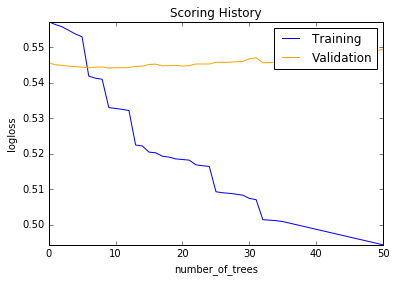

In [29]:
print "AUC: ", gbm_model.auc()
print "accuracy: ", gbm_model.accuracy()
gbm_model.plot()

In [30]:
gbm_model_2 = H2OGradientBoostingEstimator(ntrees=65,seed=1)
gbm_model_2.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [31]:
print "AUC: ", gbm_model_2.auc()
print "accuracy: ", gbm_model_2.accuracy()
# gbm_model_2.plot()

# H2OGradientBoostingEstimator.scoring_history(gbm_model_2)
# plot(h2o.pe)

AUC:  0.762872324658
accuracy:  [[0.6623931204751395, 0.7983019258645683]]


In [32]:
prediction = gbm_model.predict(hdf_validate[0])

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [33]:
pdf_pred=prediction.as_data_frame()

In [34]:
print 'prediction unique values:', pdf_pred['predict'].unique()
print pdf_pred['predict'][0:10]
print hdf_validate.head(10)

prediction unique values: [1 0]
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: predict, dtype: int64


C1,answers_yn
"{'butter': 1, 'peanut': 1, 'contain': 1, 'does': 1, 'cholesterol': 1}",0
"{'harmful': 1, 'springtails': 1, 'are': 1}",0
"{'does': 1, 'have': 1, 'signature': 1, 'assistance': 1, 'roadside': 1, 'visa': 1}",1
"{'tesla': 1, 'new': 1, 'is': 1, 'hybrid': 1, 'the': 1}",1
"{'a': 1, 'is': 1, 'plant': 1, 'moss': 1, 'spanish': 1}",1
"{'did': 1, 'on': 1, 'landed': 1, 'us': 1, 'moon': 1}",1
"{'farmhouse': 1, 'sinks': 1, 'laminate': 1, 'countertops': 1, 'with': 1, 'can': 1}",0
"{'on': 1, 'i': 1, 'saves': 1, 'xbox': 1, 'pc': 1, 'can': 1, 'put': 1, 'my': 1}",1
"{'for': 1, 'is': 1, 'there': 1, 'an': 1, 'limit': 1, 'learning': 1, 'speech': 1, 'age': 1}",0
"{'counsel': 1, 'of': 1, 'an': 1, 'not': 1, 'does': 1, 'are': 1, 'employee': 1, 'partner': 1, 'you': 1, 'or': 1, 'mean': 1}",0


# Playing with data
1. clean it
2. then word cloud

In [35]:
# import

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [37]:
tmp_str = str()
for i in df_train_sub.iloc[:,0]:
    tmp_str += i

In [38]:
wordcloud = WordCloud().generate(tmp_str)

In [39]:
def plot_wordCloud(wordcloud):
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [40]:
token = nltk.word_tokenize(tmp_str)
tf = nltk.FreqDist(token)

In [41]:
# Remove punctuation and stop words
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))

stop_words.add('?')


filtered_sentence = [w for w in token if not w in stop_words]

In [42]:
tf = nltk.FreqDist(filtered_sentence)


In [43]:
tf_lst = tf.items()

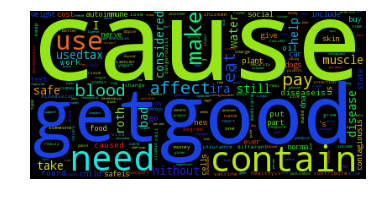

In [44]:
wordcloud=WordCloud().generate_from_frequencies(tf_lst)

plot_wordCloud(wordcloud)

In [45]:
df= pd.DataFrame(tf_lst)

In [46]:
idx = df[df.columns[1]]>30

print max(df[df.columns[1]])
print len(df[idx][df.columns[1]])

df[idx].head()

165
34


,0,1
43,diseaseis,36
437,ira,54
1053,take,53
1242,I,45
1431,caused,33


In [47]:
df_idx = df[idx]

In [48]:
lst_idx=[]
for i in range (0,len(df_idx)):
    tup = (df_idx.iloc[i,0], df_idx.iloc[i,1])
    lst_idx.append(tup)

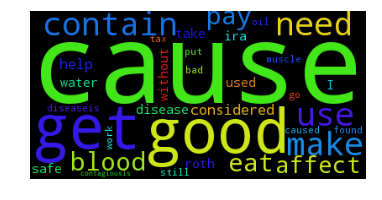

In [49]:
wordcloud=WordCloud().generate_from_frequencies(lst_idx)

plot_wordCloud(wordcloud)

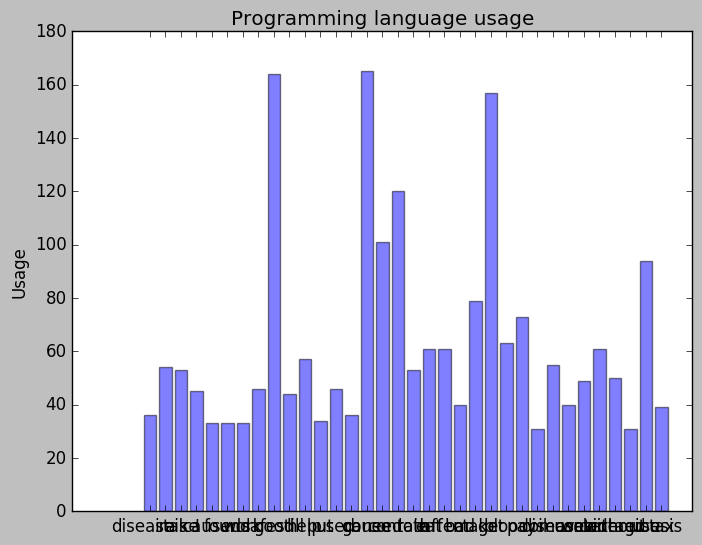

In [50]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
# objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')

objects = tuple(df_idx[0])

y_pos = np.arange(len(objects))

performance = list(df_idx[1])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

# Build model after removing stops words

In [51]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))

# stop_words.add('?')

def rm_punct(token):
    filtered_sentence = [w for w in token if not w in stop_words]
    return filtered_sentence

In [52]:
def term_fre(doc):
    token = nltk.word_tokenize(doc)
    tf = nltk.FreqDist(rm_punct(token))
#     print tf
    return dict(tf)

In [53]:
lst_tf = []
for i in df_train_sub.iloc[:,0]:
    lst_tf.append(term_fre(i))

In [88]:
hdf_tf=h2o.H2OFrame(lst_tf)

hdf_target = h2o.H2OFrame(pd.DataFrame(df_train_sub.answers_yn))

hdf = h2o.H2OFrame.cbind(hdf_tf,h2o.H2OFrame.asfactor(hdf_target))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [55]:
hdf.head()

C1,answers_yn
"{'ronald': 1, 'reagan': 1, 'democrat': 1}",1
"{'pay': 1, 'game': 1, 'shows': 1, 'contestants': 1}",1
"{'butter': 1, 'peanut': 1, 'contain': 1, 'cholesterol': 1}",0
"{'lane': 1, 'right': 1, 'carriageway': 1, 'hand': 1, 'turn': 1, 'take': 1, 'dual': 1, 'left': 1, 'roundabout': 1}",0
"{'felony': 1, 'assault': 1, 'armed': 1}",1
"{'silverbeet': 1, 'chard': 1}",1
"{'harmful': 1, 'springtails': 1}",0
"{'angora': 1, 'good': 1, 'goats': 1, 'meat': 1}",1
"{'angora': 1, 'good': 1, 'goats': 1, 'meat': 1}",0
"{'assistance': 1, 'visa': 1, 'signature': 1, 'roadside': 1}",1


In [56]:
hdf_train, hdf_validate=hdf.split_frame(ratios=[0.75], seed =1)

In [57]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [58]:
nb =H2ONaiveBayesEstimator(seed =1)
nb.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [59]:
nb.auc()

0.009103803952627752

In [60]:
gbm_model = H2OGradientBoostingEstimator(ntrees=10,seed =1, model_id = 'gbm10')
gbm_model.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


AUC:  0.629769183028
accuracy:  [[0.7063278899952814, 0.765997100849037]]


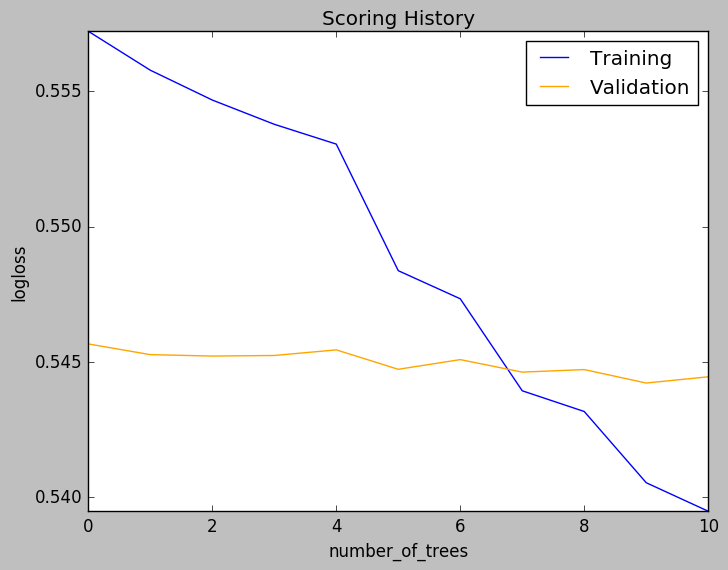

In [61]:
print "AUC: ", gbm_model.auc()
print "accuracy: ", gbm_model.accuracy()
gbm_model.plot()

In [62]:
prediction = gbm_model.predict(hdf_validate[0])

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [63]:
pdf_pred=prediction.as_data_frame()

In [64]:
print 'prediction unique values:', pdf_pred['predict'].unique()
print pdf_pred['predict'][0:10]
print hdf_validate.head(10)

prediction unique values: [1]
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: predict, dtype: int64


C1,answers_yn
"{'butter': 1, 'peanut': 1, 'contain': 1, 'cholesterol': 1}",0
"{'harmful': 1, 'springtails': 1}",0
"{'assistance': 1, 'visa': 1, 'signature': 1, 'roadside': 1}",1
"{'tesla': 1, 'new': 1, 'hybrid': 1}",1
"{'plant': 1, 'moss': 1, 'spanish': 1}",1
"{'landed': 1, 'us': 1, 'moon': 1}",1
"{'farmhouse': 1, 'laminate': 1, 'sinks': 1, 'countertops': 1}",0
"{'put': 1, 'pc': 1, 'saves': 1, 'xbox': 1}",1
"{'limit': 1, 'age': 1, 'speech': 1, 'learning': 1}",0
"{'employee': 1, 'partner': 1, 'counsel': 1, 'mean': 1}",0


In [65]:
gbm_model.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.646719054372: 


,0,1,Error,Rate
0,52.0,1133.0,0.9561,(1133.0/1185.0)
1,0.0,3644.0,0.0,(0.0/3644.0)
Total,52.0,4777.0,0.2346,(1133.0/4829.0)


In [66]:
gbm_model.recall

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm10
Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,10.0,10.0,5639.0,5.0,5.0,5.0,13.0,20.0,17.3




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.178292338632
RMSE: 0.422246774566
LogLoss: 0.539488017897
Mean Per-Class Error: 0.417101807723
AUC: 0.629769183028
Gini: 0.259538366056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.646719054372: 


,0,1,Error,Rate
0,52.0,1133.0,0.9561,(1133.0/1185.0)
1,0.0,3644.0,0.0,(0.0/3644.0)
Total,52.0,4777.0,0.2346,(1133.0/4829.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6467191,0.8654554,91.0
max f2,0.6467191,0.9414561,91.0
max f0point5,0.7426043,0.8068959,69.0
max accuracy,0.7063279,0.7659971,84.0
max precision,0.8973293,1.0,0.0
max recall,0.6467191,1.0,91.0
max specificity,0.8973293,1.0,0.0
max absolute_mcc,0.7233171,0.1833520,78.0
max min_per_class_accuracy,0.7547104,0.5397914,61.0
max mean_per_class_accuracy,0.7492397,0.5828982,62.0


Gains/Lift Table: Avg response rate: 75.46 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0109754,0.8740834,1.3251921,1.3251921,1.0,1.0,0.0145445,0.0145445,32.5192097,32.5192097
,2,0.0200870,0.8386083,1.3251921,1.3251921,1.0,1.0,0.0120746,0.0266191,32.5192097,32.5192097
,3,0.0314765,0.8300253,1.3251921,1.3251921,1.0,1.0,0.0150933,0.0417124,32.5192097,32.5192097
,4,0.0418306,0.8264045,1.3251921,1.3251921,1.0,1.0,0.0137212,0.0554336,32.5192097,32.5192097
,5,0.0503210,0.7983582,1.2928703,1.3197386,0.9756098,0.9958848,0.0109769,0.0664105,29.2870338,31.9738631
,6,0.1644233,0.7775160,1.0846854,1.1566223,0.8185118,0.8727960,0.1237651,0.1901756,8.4685364,15.6622321
,7,0.2151584,0.7665580,1.1196521,1.1479046,0.8448980,0.8662175,0.0568057,0.2469813,11.9652098,14.7904607
,8,0.3392007,0.7598765,1.0353755,1.1067538,0.7813022,0.8351648,0.1284303,0.3754116,3.5375461,10.6753839
,9,0.5011390,0.7569835,1.0133822,1.0765817,0.7647059,0.8123967,0.1641054,0.5395170,1.3382192,7.6581678
,10,0.6289087,0.7492397,1.0180568,1.0646917,0.7682334,0.8034244,0.1300768,0.6695939,1.8056813,6.4691708




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.179408753089
RMSE: 0.423566704415
LogLoss: 0.544453845588
Mean Per-Class Error: 0.485139319548
AUC: 0.516889325433
Gini: 0.0337786508655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.435075931487: 


,0,1,Error,Rate
0,0.0,379.0,1.0,(379.0/379.0)
1,0.0,1233.0,0.0,(0.0/1233.0)
Total,0.0,1612.0,0.2351,(379.0/1612.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4350759,0.8667838,63.0
max f2,0.4350759,0.9420844,63.0
max f0point5,0.6698231,0.8046512,58.0
max accuracy,0.6467191,0.7655087,59.0
max precision,0.8887874,1.0,0.0
max recall,0.4350759,1.0,63.0
max specificity,0.8887874,1.0,0.0
max absolute_mcc,0.6698231,0.0745529,58.0
max min_per_class_accuracy,0.7569835,0.5125710,36.0
max mean_per_class_accuracy,0.7569835,0.5148607,36.0


Gains/Lift Table: Avg response rate: 76.49 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0105459,0.8347839,0.8459520,0.8459520,0.6470588,0.6470588,0.0089213,0.0089213,-15.4047994,-15.4047994
,2,0.0229529,0.8157155,1.2420114,1.0600381,0.95,0.8108108,0.0154096,0.0243309,24.2011354,6.0038140
,3,0.0303970,0.8064694,1.0894836,1.0672493,0.8333333,0.8163265,0.0081103,0.0324412,8.9483644,6.7249284
,4,0.0403226,0.7981604,1.0622466,1.0660178,0.8125,0.8153846,0.0105434,0.0429846,6.2246553,6.6017843
,5,0.0545906,0.7928328,1.2505377,1.1142446,0.9565217,0.8522727,0.0178427,0.0608273,25.0537748,11.4244636
,6,0.1805211,0.7775160,0.9918058,1.0288320,0.7586207,0.7869416,0.1248986,0.1857259,-0.8194200,2.8831977
,7,0.2034739,0.7753779,0.9186997,1.0164085,0.7027027,0.7774390,0.0210868,0.2068127,-8.1300278,1.6408522
,8,0.3548387,0.7598765,1.0126840,1.0148197,0.7745902,0.7762238,0.1532847,0.3600973,1.2683978,1.4819730
,9,0.5055831,0.7569835,1.0114712,1.0138213,0.7736626,0.7754601,0.1524736,0.5125710,1.1471235,1.3821345
,10,0.6290323,0.7492397,0.9723231,1.0056772,0.7437186,0.7692308,0.1200324,0.6326034,-2.7676908,0.5677210



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-01-11 11:30:06,0.021 sec,0.0,0.4303196,0.5572164,0.5,1.0,0.2453924,0.4241932,0.5456676,0.5,1.0,0.2351117
,2017-01-11 11:30:06,0.047 sec,1.0,0.4296750,0.5557783,0.5481050,1.2770033,0.2433216,0.4240096,0.5452718,0.5144787,1.0023250,0.2351117
,2017-01-11 11:30:06,0.077 sec,2.0,0.4291571,0.5546757,0.5499353,1.2770033,0.2433216,0.4239788,0.5452193,0.5102845,1.0056772,0.2351117
,2017-01-11 11:30:06,0.108 sec,3.0,0.4287301,0.5537799,0.5514084,1.2770033,0.2433216,0.4239850,0.5452405,0.5077091,0.9684299,0.2351117
,2017-01-11 11:30:06,0.137 sec,4.0,0.4283833,0.5530480,0.5514359,1.2786941,0.2433216,0.4240916,0.5454477,0.5075422,1.0056772,0.2351117
,2017-01-11 11:30:06,0.168 sec,5.0,0.4262929,0.5483729,0.5910947,1.3251921,0.2350383,0.4237468,0.5447306,0.5141534,1.0056772,0.2351117
,2017-01-11 11:30:06,0.206 sec,6.0,0.4258334,0.5473350,0.5999396,1.3251921,0.2346241,0.4239161,0.5450882,0.5109179,0.7690473,0.2351117
,2017-01-11 11:30:06,0.250 sec,7.0,0.4242403,0.5439365,0.6058840,1.3251921,0.2346241,0.4236696,0.5446264,0.5102727,0.7690473,0.2351117
,2017-01-11 11:30:06,0.290 sec,8.0,0.4239245,0.5431717,0.6171001,1.3251921,0.2346241,0.4237246,0.5447200,0.5152940,0.7690473,0.2351117
,2017-01-11 11:30:06,0.334 sec,9.0,0.4226861,0.5405404,0.6183451,1.3251921,0.2344171,0.4234680,0.5442229,0.5176394,0.8459520,0.2351117


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C1,1764.7327881,1.0,1.0


<bound method ?.recall of >

In [67]:
fpr, tpr = gbm_model.roc(valid=True)
roc_valid = gbm_model.roc(valid=True)
roc_train= gbm_model.roc()

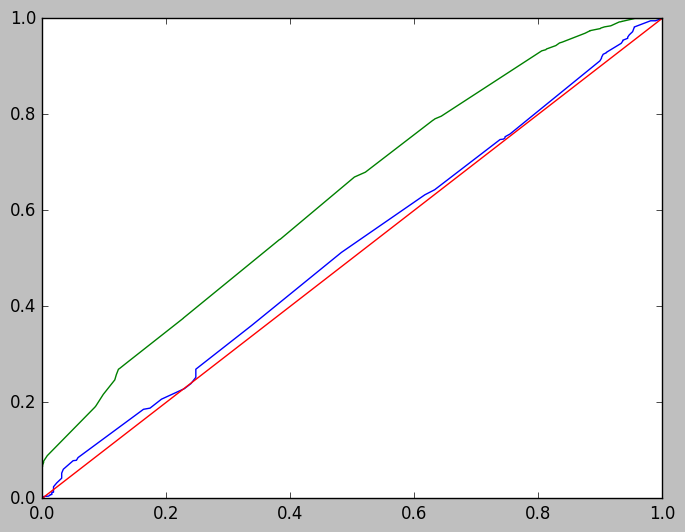

In [68]:
plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))

# include Description column

In [69]:
des_df = pd.read_csv('D:/marco/vr_chat-master/Marco/train_yn.csv')

In [74]:
print des_df['query_type'].unique()
print range(0,len(des_df['query_type'].unique()))

['description' 'entity' 'numeric' 'person' 'location']
[0, 1, 2, 3, 4]


In [85]:
des_df=des_df.replace(des_df['query_type'].unique(),range(0,len(des_df['query_type'].unique())))
# des_df['query_type']

In [92]:
hdf=h2o.H2OFrame.cbind(hdf, h2o.H2OFrame(list(des_df['query_type'])))


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [93]:
hdf_train, hdf_validate=hdf.split_frame(ratios=[0.75], seed =1)

In [94]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [95]:
gbm_model = H2OGradientBoostingEstimator(ntrees=10,seed =1, model_id = 'gbm10')
gbm_model.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


AUC:  0.629769183028
accuracy:  [[0.7063278899952814, 0.765997100849037]]


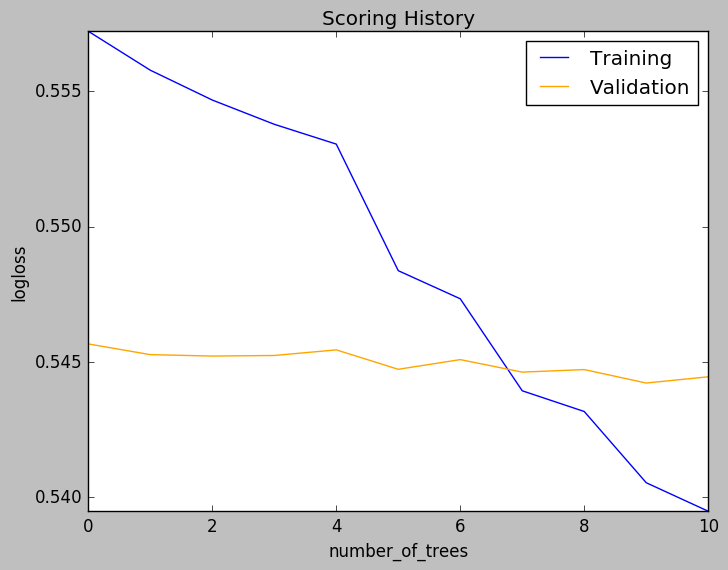

In [96]:
print "AUC: ", gbm_model.auc()
print "accuracy: ", gbm_model.accuracy()
gbm_model.plot()

In [98]:
fpr, tpr = gbm_model.roc(valid=True)
roc_valid = gbm_model.roc(valid=True)
roc_train= gbm_model.roc()

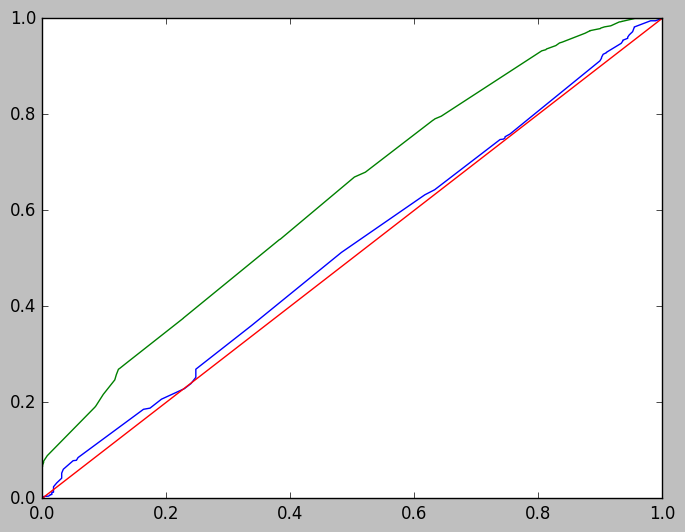

In [99]:
plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))